In [6]:
import pandas as pd
import numpy as np
import datetime, pickle
import matplotlib.pyplot as plt
import time
import tqdm
import dateutil.parser
import os
import re
import collections

years_dict = {"03":[54,55],
              "04":[54,55,56],
              "05":[55,56],
              "06":[56,57,58,59],
              "07":[57,58,59],
              "08":[61,62],
              "09":[60,61],
              "10":[61,62,63,64],
              "11":[62,63],
              "12":[63,64,65],
              "13":[64,65,66,67],
              "14":[65,66],
              "15":[66,67,68],
              "16":[68,69,70,71,72],
              "17":[68,69],
              "18":[68,69,70,71],
              "19":[69,70,71,72,73],
              "20":[70,71,72],
              "21":[72,73,74],
              "22":[73,74,75,76,77,78,79,80,81,82],
              "23":[76,77,78],
              "24":[78,79,80],
              "25":[81,82,83,84],
              "26":[83,84],
              "27":[84,85,86,87],
              "28":[86,87,88],
              "29":[87,88],
              "30":[87,88,89,90,91],
              "31":[89,90,91]}

month_nums = {'jan':1,
              'feb':2,
              'fab':2,
              'mch':3,
              'mar':3,
              'apr':4,
              'may':5,
              'jun':6,
              'jul':7,
              'aug':8,
              'spt':9,
              'sep':9,
              'oct':10,
              'nov':11,
              'dec':12}

precip_dir = '/home/robbie/Dropbox/SP_W99_Drifters/Data/W99_clean/PRECIP/'
met_dir = '/home/robbie/Dropbox/Data/W99_raw/MET/'

In [54]:
met_fields = ['Station ID',
                  "Year",
                  "Month",
                  "Day",
                  "Time",
                  "Latitude",
                  "Longitude",
                  "Air temperature",
                  "Relative humidity",
                  "Sea level pressure",
                  "Wind direction",
                  "Wind speed",
                  "Total cloudiness",
                  "Low cloudiness",
                  "Surface temperature"]

met_dict = {}

for station_num in tqdm.tqdm(years_dict.keys()):
    
    met_dict[station_num] = {}

    met_data = pd.read_csv(f'{met_dir}METNP_{station_num}.DAT',
                           delim_whitespace=True,
                           index_col=False,
                           names=met_fields)

    met_data.replace([-9.9,-9,9999], np.nan, inplace=True)

    met_data['Year'] = met_data['Year'] + 1900

    met_data['date'] = pd.to_datetime(met_data[['Year','Month','Day']])

    fictional_dates = [ind for ind, date in enumerate( met_data['date']) if pd.isnull(date)]

    met_data.drop(fictional_dates,inplace=True)

    hours_list = [datetime.timedelta(hours=x) for x in met_data['Time']]

    met_data['UTC'] = [(x+y)-datetime.timedelta(hours=3) for x, y in zip(met_data['date'],hours_list)]

    met_data.drop(columns=['date','Month','Day','Time','Station ID'],inplace=True)
    
    met_data['doy'] = [dt.timetuple().tm_yday for dt in met_data['UTC']]

    met_data.set_index(['UTC'],inplace=True,drop=True)
    
    years = set(met_data['Year'])
    
    for year in years:
        
        met_dict[station_num][year] = met_data[met_data['Year']==year]

pickle.dump(met_dict,open('../../pickles/met_dict','wb'))

100%|███████████████████████████████████████████| 29/29 [00:02<00:00, 11.97it/s]


In [53]:
met_data

,Year,Latitude,Longitude,Air temperature,Relative humidity,Sea level pressure,Wind direction,Wind speed,Total cloudiness,Low cloudiness,Surface temperature
UTC,,,,,,,,,,,
1988-11-30 21:00:00,1988.0,NaN,NaN,-30.1,80.0,1006.7,340.0,7.0,8.0,0.0,-30.0
1988-12-01 00:00:00,1988.0,NaN,NaN,-31.8,80.0,1007.0,350.0,5.0,8.0,0.0,-32.0
1988-12-01 03:00:00,1988.0,NaN,NaN,-31.6,80.0,1006.7,350.0,5.0,9.0,9.0,-31.0
1988-12-01 06:00:00,1988.0,NaN,NaN,-32.4,80.0,1007.1,320.0,5.0,9.0,0.0,-32.0
1988-12-01 09:00:00,1988.0,NaN,NaN,-32.9,79.0,1008.2,340.0,5.0,2.0,0.0,-33.0
...,...,...,...,...,...,...,...,...,...,...,...
1991-03-31 06:00:00,1991.0,72.102,-148.785,-28.5,80.0,1013.7,145.0,3.0,2.0,0.0,-30.0
1991-03-31 09:00:00,1991.0,72.102,-148.785,-29.7,80.0,1013.5,125.0,4.0,2.0,0.0,-31.0
1991-03-31 12:00:00,1991.0,72.102,-148.785,-29.3,81.0,1013.3,140.0,4.0,3.0,0.0,-31.0


In [24]:
solar = pd.read_csv('/home/robbie/Dropbox/SP_W99_Drifters/Data/W99_clean/SOLAR/DAILYAVG.DAT',
                    delim_whitespace=True,index_col=False,
                    names=['NP','year','month',
                           'day','tempC','RH%',
                           'pressure hPa','wind speed', 
                           'total cloud', 'low cloud',
                           'surface temp','num obs',
                           'latitude','longitude','diffuse radiation',
                           'direct radiation','global radiation',
                           'reflected radiation','albedo','net radiation'])

solar.replace(to_replace=9999,value=np.nan,inplace=True)

solar['date'] = [datetime.date(year=y+1900,month=m,day=d) for (y,m,d) in zip(solar['year'],solar['month'],solar['day'])]

solar['doy'] = [dt.timetuple().tm_yday for dt in solar['date']]

# solar['albedo'] = 100*solar['reflected radiation']/(solar['global radiation']+solar['reflected radiation'])

solar

,NP,year,month,day,tempC,RH%,pressure hPa,wind speed,total cloud,low cloud,...,latitude,longitude,diffuse radiation,direct radiation,global radiation,reflected radiation,albedo,net radiation,date,doy
0,17,68,5,17,-13.1,83.0,1016.2,2,NaN,NaN,...,80.975,163.608,NaN,NaN,NaN,NaN,NaN,NaN,1968-05-17,138
1,17,68,5,18,-16.4,75.0,1021.5,1,NaN,NaN,...,81.018,163.520,NaN,NaN,NaN,NaN,NaN,NaN,1968-05-18,139
2,17,68,5,19,-15.7,77.0,1029.3,1,0.0,0.0,...,81.020,163.410,NaN,NaN,NaN,NaN,NaN,NaN,1968-05-19,140
3,17,68,5,20,-10.2,82.0,1024.3,5,NaN,NaN,...,81.087,163.458,NaN,NaN,NaN,NaN,NaN,NaN,1968-05-20,141
4,17,68,5,21,-4.6,96.0,1011.4,5,10.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968-05-21,142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15716,31,91,3,25,-30.7,81.0,1025.8,2,1.0,0.0,...,72.117,211.062,49.0,NaN,107.0,81.0,NaN,NaN,1991-03-25,84
15717,31,91,3,26,-30.8,80.0,1017.9,5,4.0,0.0,...,72.117,211.058,39.0,NaN,111.0,85.0,NaN,NaN,1991-03-26,85
15718,31,91,3,27,-28.2,83.0,1012.2,6,4.0,0.0,...,72.103,211.188,39.0,NaN,123.0,92.0,NaN,3.0,1991-03-27,86
15719,31,91,3,28,-29.8,80.0,1004.0,3,3.0,0.0,...,72.102,211.203,35.0,NaN,119.0,91.0,NaN,NaN,1991-03-28,87


In [43]:
solar_dict = {}

for NP in set(solar['NP']):
    
    solar_dict[NP] = {}
    
    df = solar[solar['NP']==NP]
    
    years = set(df['year'])
    
    for year in years:
        
        year_df = df[df['year']==year]
        
        solar_dict[NP][year] = year_df
        
#         if year_df['global radiation'].shape[0] > 50:
            
#             print(year_df['global radiation'].shape[0])
#             plt.plot(year_df['doy'],year_df['global radiation'])
#             plt.show()

pickle.dump(solar_dict,open('../../pickles/solar_df','wb'))

In [45]:
NP, year

(31, 91)

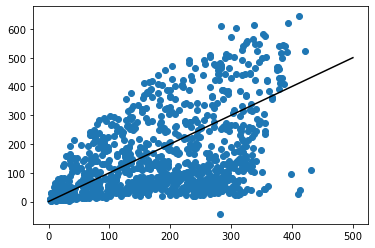

In [21]:
plt.scatter(solar['global radiation'],solar['diffuse radiation'] + solar['direct radiation']-solar['reflected radiation'])
plt.plot([0,500],[0,500],color='k')

In [33]:
solar[pd.notna(solar['direct radiation'])]

,NP,year,month,day,tempC,RH%,pressure hPa,wind speed,total cloud,low cloud,...,latitude,longitude,diffuse radiation,direct radiation,global radiation,reflected radiation,albedo,net radiation,date,doy
9636,25,82,5,1,-15.1,86.0,1022.4,4,9.0,0.0,...,NaN,NaN,151.0,197.0,204.0,174.0,NaN,NaN,1982-05-01,121
9637,25,82,5,2,-18.8,87.0,1027.3,2,4.0,0.0,...,81.873,163.513,137.0,276.0,213.0,180.0,NaN,NaN,1982-05-02,122
9638,25,82,5,3,-15.0,89.0,1030.6,1,5.0,0.0,...,81.960,162.780,114.0,360.0,233.0,197.0,NaN,NaN,1982-05-03,123
9639,25,82,5,4,-12.7,92.0,1032.2,2,10.0,0.0,...,NaN,NaN,181.0,25.0,185.0,162.0,NaN,NaN,1982-05-04,124
9641,25,82,5,6,-18.8,87.0,1034.8,2,5.0,2.0,...,81.817,162.395,167.0,253.0,236.0,198.0,NaN,NaN,1982-05-06,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13651,29,88,5,27,-7.3,93.0,1020.5,3,NaN,NaN,...,86.017,72.753,252.0,1.0,253.0,229.0,NaN,NaN,1988-05-27,148
13652,29,88,5,28,-7.7,95.0,1023.7,5,10.0,9.0,...,86.025,72.353,248.0,2.0,249.0,226.0,NaN,NaN,1988-05-28,149
13653,29,88,5,29,-4.8,96.0,1021.9,7,NaN,NaN,...,86.050,71.328,265.0,24.0,274.0,242.0,NaN,NaN,1988-05-29,150
13654,29,88,5,30,-4.5,89.0,1025.0,6,1.0,0.0,...,86.083,70.110,130.0,600.0,359.0,308.0,NaN,NaN,1988-05-30,151


In [1]:
solar

NameError: name 'solar' is not defined

In [36]:
pickle.dump(solar, open('pickles/solar.p','wb'))

In [25]:
solar['surface temp'].shape, np.count_nonzero(np.nan_to_num(solar['surface temp']))

((15721,), 10505)

In [12]:
solar[solar['NP'] == 30]

,NP,year,month,day,tempC,RH%,pressure hPa,wind speed,total cloud,low cloud,surface temp,num obs,latitude,longitude,diffuse radiation,direct radiation,global radiation,reflected radiation,albedo,net radiation
13656,30,87,11,1,-12.7,88,1021.2,2,8,1,-12,8,74.788,185.278,9999,9999,9999,9999,9999,9999
13657,30,87,11,2,-15.5,86,1020.0,2,10,6,-13,8,9999.000,9999.000,9999,9999,9999,9999,9999,9999
13658,30,87,11,3,-16.6,85,1020.9,4,10,7,-16,8,74.862,185.458,9999,9999,9999,9999,9999,9999
13659,30,87,11,4,-22.5,81,1025.4,1,10,8,-20,8,74.865,185.485,9999,9999,9999,9999,9999,9999
13660,30,87,11,5,-18.6,83,1027.3,3,10,10,-17,8,9999.000,9999.000,9999,9999,9999,9999,9999,9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14867,30,91,2,24,-36.7,71,1009.3,4,4,1,-37,8,9999.000,9999.000,9999,9999,9999,9999,9999,-51
14868,30,91,2,25,-32.1,72,1011.6,6,4,0,-32,8,82.532,234.025,9999,9999,9999,9999,9999,-37
14869,30,91,2,26,-34.0,71,1018.7,4,4,0,-34,8,82.542,234.135,9999,9999,9999,9999,9999,-42
14870,30,91,2,27,-36.3,71,1024.1,4,3,0,-36,8,9999.000,9999.000,9999,9999,9999,9999,9999,-41
